# Research Summary
*Or rather a hindsight discussion*

### Overall projects
1. Experimenting with transformers, rnns and retnet
1. Collecting QuEra Aquila data and finding the temperature
1. Other key tests

## Table of Contents
1. [Collecting QuEra Aquila data and finding temperature](#quantum-computer-temperature)
    1. [QMC temperature differentiation](#qmc-temperature-differentiation)
        1. [State probability plot](#plot-1)
        1. [Jansen Shannon Divergence plot](#plot-2)
        1. [Average occupation plot](#plot-3)
    1. [Aquila atom configuration testing](#aquila-atom-configuration-testing)
        1. [Aquila input](#aquila-input)
        1. [Atom array independence testing](#independence-testing)
    1. [Aquila data Analysis](#aquila-data-analysis)
        1. [Shot duration](#shot-duration)
        1. [Finding Temperature](#finding-temperature)
        1. [Finding Aquila Tuning Parameters](#finding-aquila-tuning-parameters)
1. [Experimenting with neural networks](#experimenting-with-neural-networks)
    1. [QMC training](#qmc-training)
        1. [Transformer design](#transformer-design)
        1. [Evaluation](#training-evaluation)
    1. [Schuyler Data Analysis](#schuyler-data)
        1. [Data analysis](#data-analysis)
        1. [Neural network training](#neural-network-training)
    1. [Combining training methods](#combining-training-methods)
1. [Miscellaneous Testing](#other-testing)
    1. [Autocorrelation testing for QMC](#autocorrelation-testing-for-qmc)
    1. [Energy vs temperature](#temperature-vs-energy)
1. [Guides](#guides)
    1. [Using AWS Braket to access Aquila](#using-aws-braket-to-access-aquila)
        1. [Getting AWS account](#getting-aws-account)
        1. [Pricing](#pricing)
        1. [Running the Quantum Computer](#running-shots-on-quantum-computer)
1. [Resources](#resources)

# Quantum Computer Temperature
## QMC temperature differentiation

The initial idea of the quantum computer temperature project was to get quantum computer data and QMC data and use KL divergence to compare them, then the $\beta$ in which the QMC data was most like the quantum computer data would be the "correct" temperature. And we can maybe use a transformer to train on quantum computer data to generate more data to work with. 

Going in, we didn't know how much noise we would be getting. We were thinking that the state would be very close to the ground state and that it would be hard to find the correct temperature. So some concerns that we wanted to look into were:
1. How much data would we need to get an accurate estimate of temperature?
1. Where on the phase space would allow us to most accurately measure the temperature?

We would have to answer each of these questions at the same time. To figure this out, I had to experiment with QMC data to see what we can learn from it.

My approach was as follows:
1. For a select point on the phase diagram (I did a point on the disordered phase, on the critical point, and in the checkerboard phase), we run QMC for various different temperatures.
1. Then taking the QMC data for some temperature, compute the probabilities of each state. Do this for the QMC data of all other temperatures. You can then compute the JSD between the probabilties of one temperature with all other temperatures. When the temperatures agree, there should be a minimum. This approach can be used to compare QMC data with real data to find which temperature the real data is.
    - KL divergence has the downside that if one probability distribution has probability 0 somewhere but the other is non-zero, the KL divergence will divergerge since you will be computing $\log 0$. JS divergence is a considerably better metric when comparing data with other data.
    - To get error bars, take some QMC data with a lot of data (I use $10^7$ shots). This will ensure that the probabilities for each state is at least quite accurate. Then sample from this probability distribution for however many samples is desired. With this resampled data, you can compute the histogram and compute the JSD with other data. You can then compute the standard deviation of the JSD calculation to get error bars. This is useful for figuring out how many samples are required to get a desired level of accuracy.
1. Another metric is to compute the average occupation of the QMC data and to match that up with the average occupation of the quantum computer data. The temperature where the average occupations match is the temperature of the quantum computer. As well, using a second metric allows for a sanity check and possibly a means to show that the data doesn't agree with the Gibbs state.
    - *Looking for different metrics can allow for assessing the differences between the quantum computer data and QMC data. It turns out that non-Gibbs distributions have average occupations with agree with the Gibbs state, so this is not the best metric.*
    - You can compute error bars by computing the standard deviation of the average occupation.

I then used the above approach to assess the different points on the phase diagram and figure out how many samples I would need to get a good value of the temperature.

### Plot 1

My means of visually assessing data is with the following kind of diagram which visualizes the probabilities of measuring each state. In the diagram, each box is an atom. When the box is yellow, it is in the rydberg state and in the ground state when black. The states are sorted by how probable they are. 

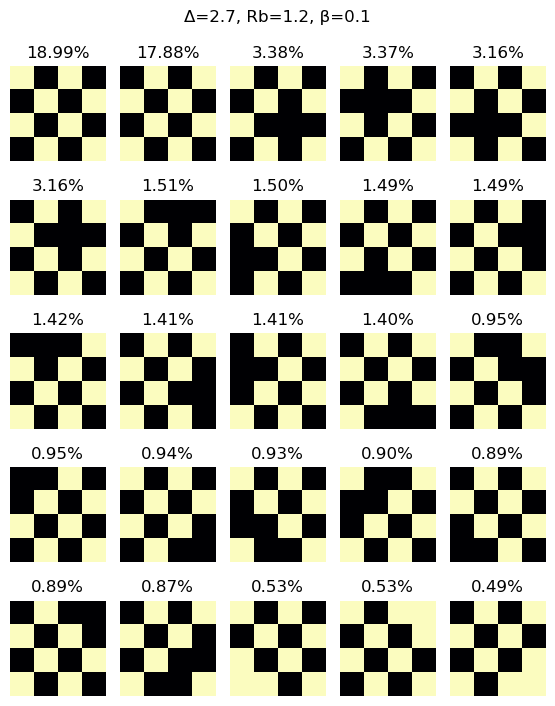

### Plot 2

The plot suggested in point (2) looks as follows. This shows how well we would in theory be able to differentiate between different temperatures. This approach mostly gives a ballpark estimate of the temperature since you can only identify the temperature to the nearest $\beta\Omega$ value which was used.

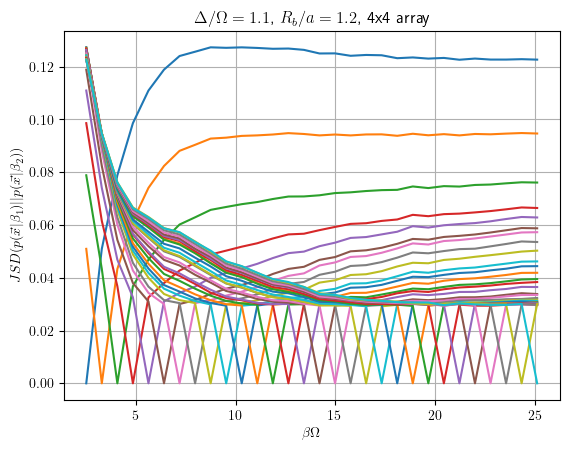

$$JSD(P||Q)=\frac{1}{2}D_{KL}(P||M)+\frac{1}{2}D_{KL}(Q||M),\qquad M=\frac{1}{2}(P+Q)$$
$$D_{KL}(P||Q)=\sum_{x\in \mathcal{D}} P(x)\log\left(\frac{P(x)}{Q(x)}\right)$$

Some things that I observed about these plots is
* Well into the checkerboard phase, most states will look quite similar even for somewhat low temperatures. Thus this would not be a good idea for a place to identify the temperature. If you are trying to find the difference between two states far into the ground state, you will not find any signal to differentiate the temperatures.
* Both the disordered phase and the critical point have many temperatures that are differentiable, though the critical point as slightly more differentiable temperatures.

### Plot 3

The plot suggest in point (3) looks as follows. I used this plot to estimate how many data points I would need to accurately measure the temperature. If you measured some average occupation with a standard deviation, you could then convert that into a temperature.

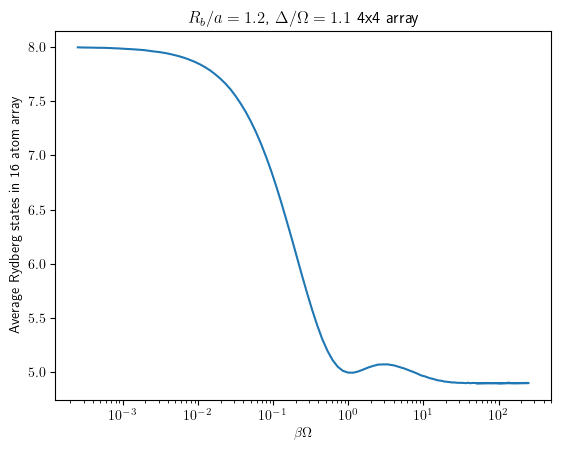

We interpret this plot in the following way
* The right of the plot is the low temperature limit, where it finds the ground state, which happens to be the lowest occupation.
* The occupation then increases when the temperature increases because the average occupation of the ground state is so low. Thermal noise allows more atoms to be rydberg atom
* There is a local maximum average occupation since it will start to favour the checkerboard pattern, which is more favourable than something completely noisy. This is a maximum because the checkerboard pattern has an occupation of 1/2 which is thermally the maximum.
* The occupation decreases since the checkerboard pattern is broken from thermal fluctuations. Sometimes extra atoms are added, but it's also very possible for atoms to be removed.
* The average occupation then steadily increases due to the high temperature allowing an increasing number of states that have high occupation. This reaches a maximum of 1/2 since that state has maximized entropy.

In different points in the phase space, such as in checkerboard phase, this second bump will not show up since the checkerboard is the ground state.

This plot gives us several regions to find the temperature in
1. If the average occupation is quite high, (exactly what is considered high depends on the point in the phase space) we can quite accurately find the temperature since the average occupation changes a lot for small changes in temperature. This is unlikely the case in the quantum computer because we know that the quantum computer has low enough temperature to allow for a checkerboard pattern.
1. We can find the temperature when the occupation decreases as temperature increases. 
1. We can find the temperature for low temperature, when the occupation increases with temperature.
1. If the temperature is sufficiently low, the average occupation will plateau and all states will be in the ground state. If we are to find the temperature of the quantum computer, we don't want this to happen.

Assuming some point in the third region, if you made some amount of measurements of the average occupation, I calculated what the corresponding range of $\beta$ would be. Ideally, we want the range of possible $\beta$ values to be as small as possible, but we can't infinitely increase the number of measurements.

| Measurements | Worse case accuracy of $\beta$ | Best case accuracy $\beta$ |
| --- | --- | --- |
| $10^4$ | bad | 0.027 |
| $10^5$ | 0.09 | 0.0086 |
| $10^6$ | 0.030 | 0.0027 |
| $10^7$ | 0.010 | 0.0008 |

My conclusion was that using around $10^5$ to $10^6$ data points was sufficient to give to the quantum computer.

## Aquila Atom Configuration Testing
### Aquila input
Now that we know how many data points we want to sample, we note that we are limited in the amount of measurements we can do with Quera's Aquila quantum computer.

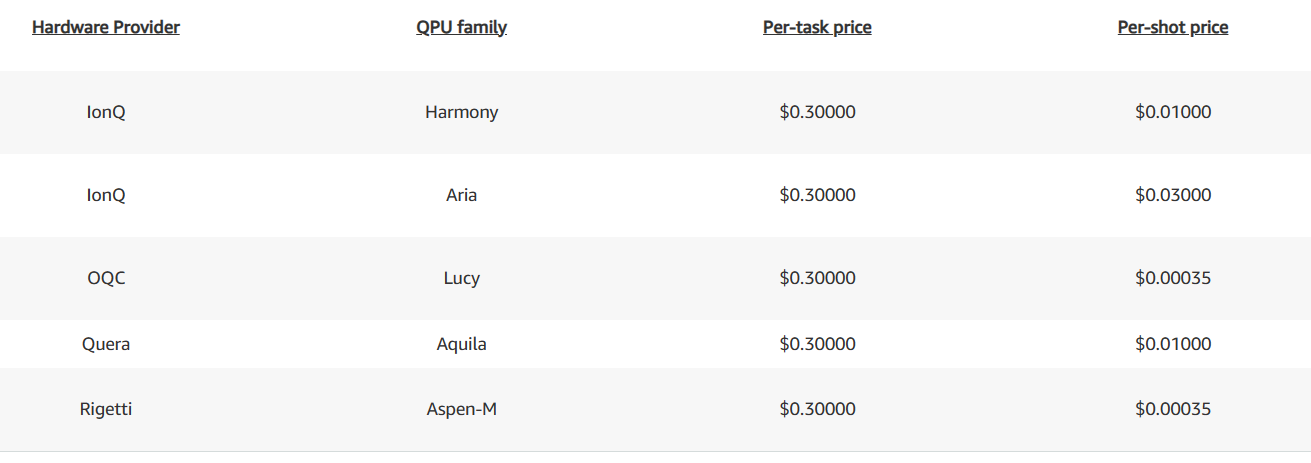

To maximize the cost per shot, you need to have each task have 1000 shots (the maximum per task) and then do a large amount of tasks. This totals to \$0.0103 per shot. So with \$5000, we can only do 485436 shots. Notably, this doesn't reach the $10^6$ mark.

In order to get more shots in, the idea was to fill the quantum computer with many 4x4 atom arrays and spatially separate them. Aquila could support a maximum of 256 atoms, but it also has a limited region height and width. There is also a limit to how close atoms can be and the maximum values of the Rabi frequency. These details can be found [here](https://arxiv.org/abs/2306.11727).

Taking all of these details into account, we were able to fit 4 4x4 atom arrays on all four corners of the field of view. The atom configuration and the input waveform looked like this:

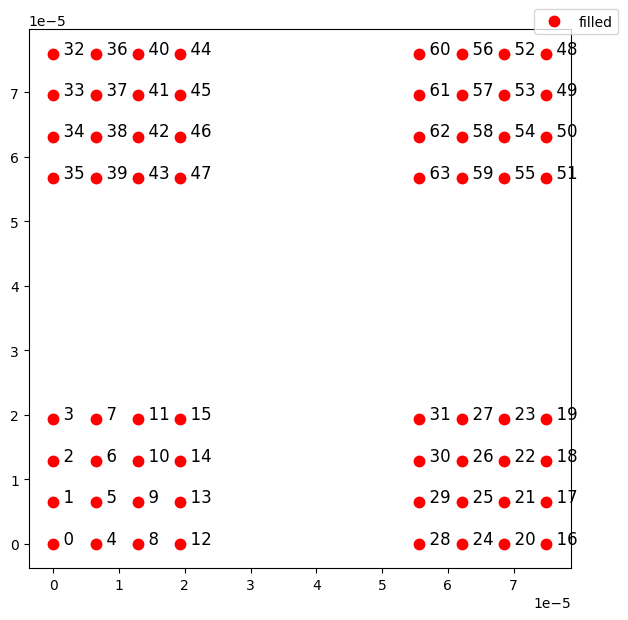

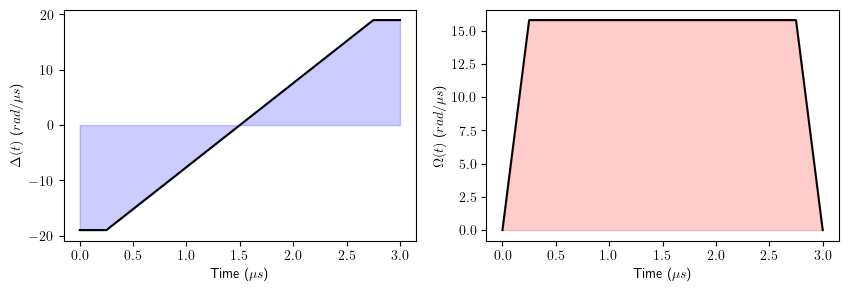

The overall shape of the waveform was copied from Anna Knorr's usage of QuEra. $\Delta$ is increased gradually for adiabatic evolution. $\Omega$ is zero to start with to put the atoms in the ground state. Then it is quickly turned to the right value so the state evolves the right way, and at the end, $\Omega$ is turned off to make the state stop evolving when the state is measured.

$\Omega$ has a maximum of 15.8 $rad/\mu s$, so this was chosen since it means that $R_b=\left(\frac{C}{\Omega}\right)^{\frac{1}{6}}$ is small and the atoms can be as close as possible to each other without changing the physics. This makes the four atom arrays as far from each other as possible.

The final $\Delta$ value, after the gradual increase, was chosen so that $\Delta/\Omega$ is the desired value. The distance between atoms is fixed to specify what $R_b/a$ is.

### Independence testing
The question now arises, is the state that I inputted actually correspond to what I want? Does the waveform inputted correspond to the right point in the phase space? And do the atom locations which I inputted actually result in four completely independent 4x4 atom arrays? 

For the first question, we can only hope that it correct. We could simulate the system, but with the tools easily available to me, doing a dynamic simulation did not scale to the system that I was interested in. So it would be very difficult to see if this waveform is the most accurate.

For the second question, I did some analysis to confirm that each of these arrays are indeed independent of each other. There are a few options to measure correlation between atoms on different arrays. Letting $n_i$ be the occupation of atom $i$ (either 0 or 1), 

$$s_{ij}=\frac{\langle n_i n_j\rangle-\langle n_i \rangle \langle n_j\rangle}{\sqrt{\langle n_i^2\rangle - \langle n_i\rangle^2}\sqrt{\langle n_j^2\rangle - \langle n_j\rangle^2}}$$
$$m_{ij}=\log\left|1-\frac{P(b|a)}{P(b)}\right|=\log\left|1-\frac{\langle n_i n_j\rangle}{\langle n_i\rangle\langle n_j\rangle}\right|$$
$$m_{ijk}=\log\left|1-\frac{P(b|ac)}{P(b)}\right|=\log\left|1-\frac{\langle n_i n_j n_k\rangle}{\langle n_i n_j\rangle\langle n_k\rangle}\right|$$

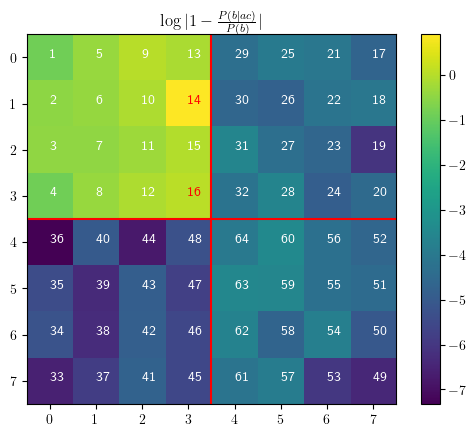
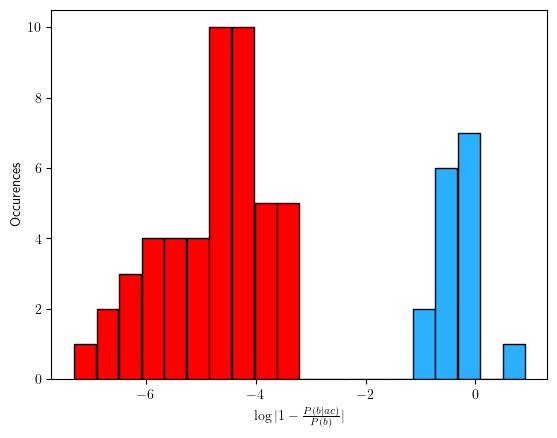

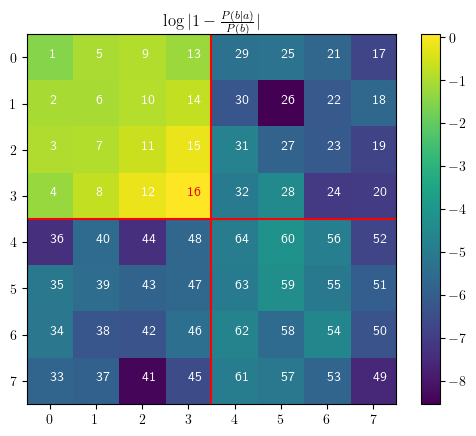
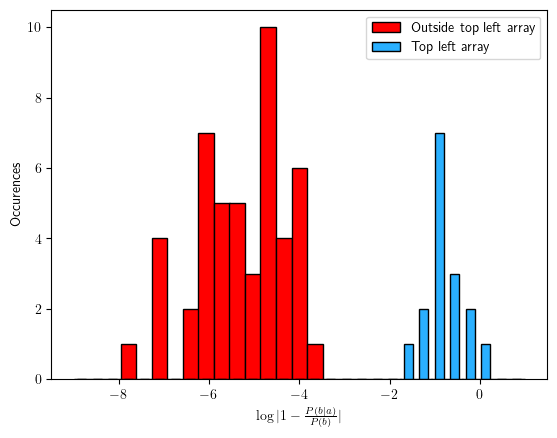

The above is for $\beta\Omega=19.6035$, which is a reasonably low temperature.

Under this metric, we are seeing an order of magnitude less correlation between points in the 4x4 array and outside. As well, atoms that are closest to the atom of interest are just as correlated to it as an atom further away. In some cases, even more so. The effect will be even more pronounced for higher temperatures (to spoil the end result, we found that the temperature was around $\beta\Omega\approx 3$, thus there would be much more thermal noise in the real case). Thus, any correlation you might see for this system is masked by noise.

## Aquila Data Analysis

### Shot duration
After a bunch of consecutive tasks from Quera were completed, each with 1000 shots, I could count the time between tasks to find the time per shot. This is a histogram of this:

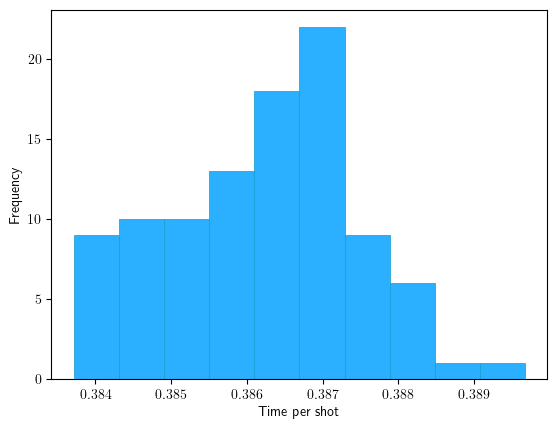

$\text{duration}=0.38622\pm 0.00126\text{ s/shot}$

### Finding Temperature
The waveform that I gave to Aquila should correspond to $\Delta/\Omega=1.2$ and $R_b/a=1.15$. I simulated this with QMC and computed the JSD between the QMC and Aquila data for many different $\beta\Omega$ values. I also plotted the average occupation as a function of $\beta\Omega$ and compared it with the average occupation computed from the Aquila data.

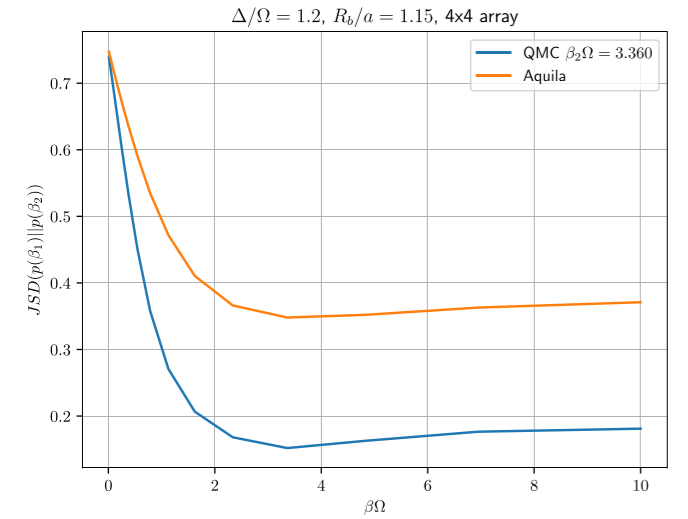
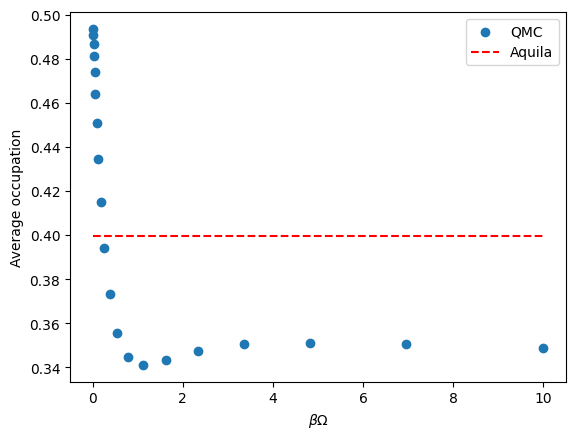

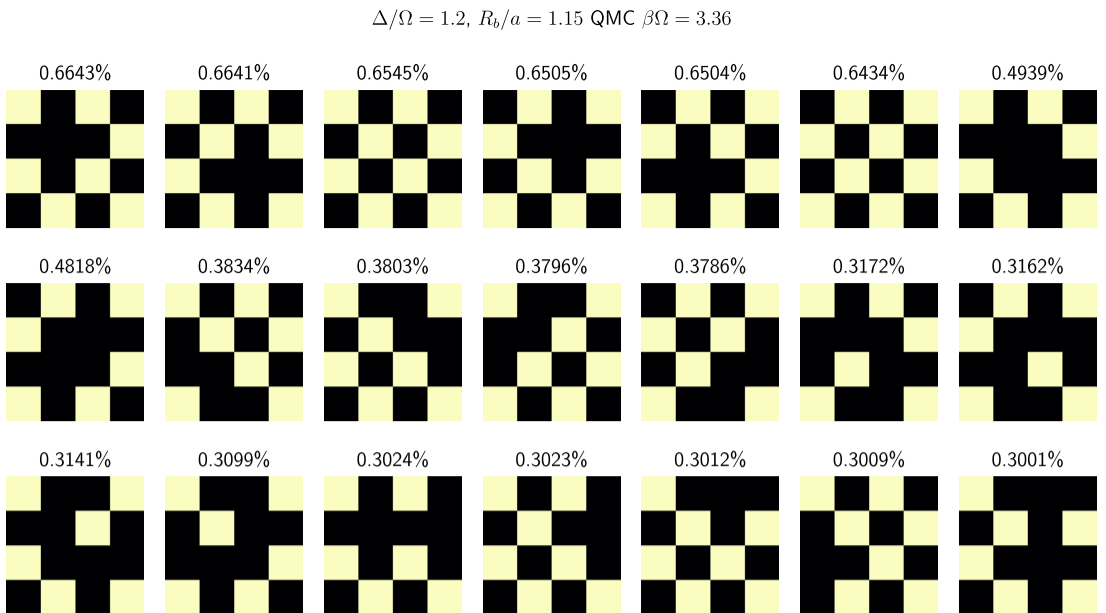
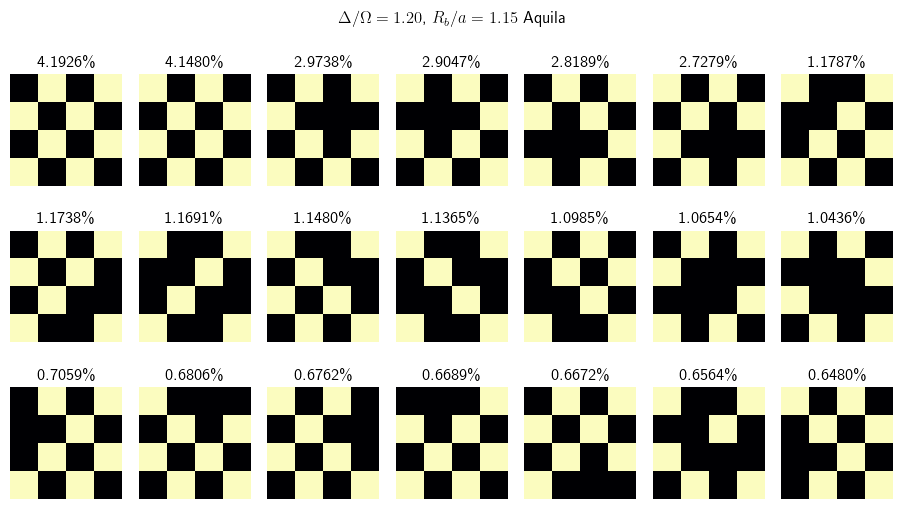

The orange plot is the JSD of $10^7$ QMC data compared with all Aquila data ($\sim 10^5$). The blue plot is the JSD of $10^7$ QMC data compared with $10^5$ QMC data resampled. This is the ideal case of when the Aquila data fully matches the QMC data. If we were to have infinite data for this computation, the JSD would be 0. 

* We notice a large discrepancy between the two JSD, but we notice that there is a minimum $\beta\Omega$ which is finite. An the minimum is around $\beta\Omega\approx 3$. 
* We also notice that the minimum $\beta\Omega$ from the average occupation plot does not match with the average occupation
* We also notice that the Aquila data has a lot of data with the checkerboard pattern. QMC data doesn't have as frequent checkerboard states, which is more expected since it is on the critical point.

This leads me to believe that the Aquila data that was obtained doesn't correspond to the correct point on the phase diagram, but instead somewhere in the checkerboard phase.

### Finding Aquila Tuning Parameters
To test this hypothesis, I will see if we can resolve all the above problems by finding the point in the phase diagram which minimizes the JSD between QMC data and Aquila data. 

When varying $\beta\Omega$ and $\Delta/\Omega$ and keeping $R_b/a=1.15$, we obtain an interpolated plot of JSD. The top curve on the first plot is the JSD of Aquila data and QMC and the bottom plot is the JSD of QMC data ($10^5$) and QMC data ($10^7$) with that temperature. The second plot is the average occupation as a function of the tuning parameters.

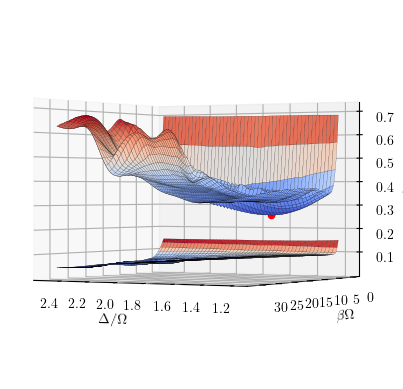
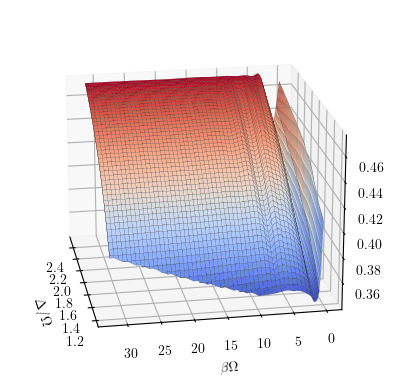

We see a minimum at $\Delta/\Omega=1.63648469,\quad \beta\Omega=2.91057046$

Though we do notice that the $\beta\Omega$ is still around the same that is was before, suggesting that are results are somewhat robuts to where on the phase diagram we are. As well, here the average occupations match quite nicely: $0.3990511$ for QMC and $0.3997578125$ for Aquila.

It also turns out that we can get a slightly improved state if we vary $R_b/a$ slightly as well.

   |real-QMC_JSD|	real-QMC_JSD_std|	QMC-QMC_JSD|	QMC-QMC_JSD_std|	$\Omega$|	$\beta$|	$\Delta/\Omega$|	$\beta\Omega$|	$R_b/a$|
|----------|-----------|----------|------------|------|--------|-------|-------|------|
|	0.228483|	0.000171|	0.07577|	0.00041|	1.0|	2.81|	1.66|	2.81|	1.2|

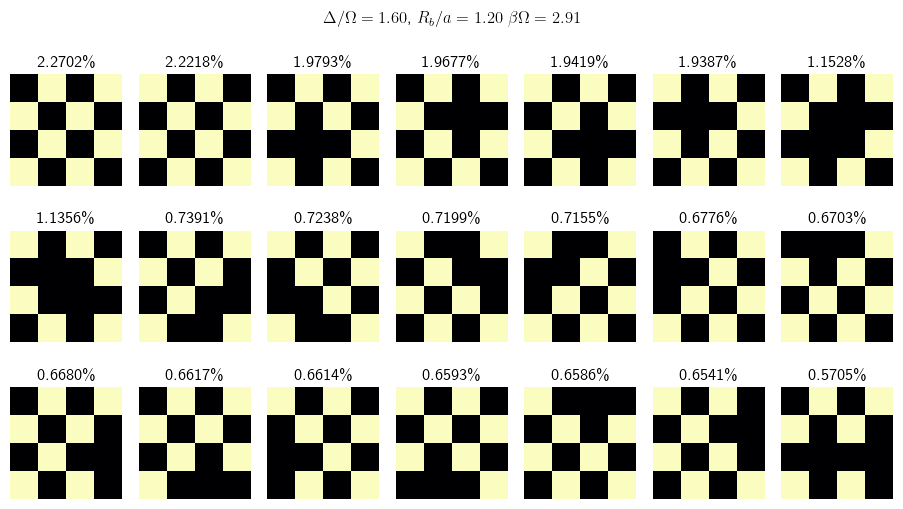

We notice here that the amount of the atoms in the checkerboard pattern are closer to the actual state but still not quite there.

In conclusion, instead of the Aquila data being on the critical point as expected it was further in the checkerboard pattern. But nonetheless, we find that the quantum computer has a temperature of $\beta\Omega\approx 3$ at this point in the phase space (where ever it is exactly).


Upon getting some more data, I did some more analysis (though less thorough)

|$\Delta_i/\Omega$ | $\Delta_f/\Omega$ | $R_b/a_i$ | $R_b/a_f$ | $\beta\Omega$ |
|------------------|-------------------|-----------|-----------|---------------|
| 1.2              | 1.66              | 1.15      | 1.2       | 2.8           |
| 1.2              | 1.6               | 1.31      | ~1.3       | 2.5           |
| 0.9              | 1.2               | 1.31      | ~1.3      | 2.5           |
| 0.8              | 1.15              | 1.15      | ~1.15      | 2.5           |

From the results here, it seems like there is a consistent shift in $\Delta/\Omega$ values from what was inputted. As well, with the accuracy that I was willing to measure, the $\beta\Omega$ values seem to be relatively consistent. This would suggest that the temperature is mostly independent of the Hamiltonian. At within this range of tested Hamiltonians.

# Experimenting with Neural Networks
## QMC training
### Transformer Design
The second project I worked on was to fiddle around with transformers. My initial goal was to see if I can train a smaller version of RydbergGPT on a single point in phase space to see how well it can learn the state. 

My neural network, (call it `transformer1`) functioned as follows:
* It was a decoder-only neural network in pytorch with a mask (I used the encoder source code, but since I was using a mask, it was effectively decoder only).
* I used normal positional encoding. I found that using [2d position encoding](https://github.com/tatp22/multidim-positional-encoding/blob/master/positional_encodings/torch_encodings.py) has little affect on the overall results. 
* As inputs to the transformer, I inputted a one-hot encoding of the spin state. That is, the input was a $(2, n)$ size tensor, where $n$ is the sequence length (ignoring batches).
* The masking was done as follows. The first output of the transformer was not based on any input. The second output of the transformer is based on the first input. The third output is based on the first 2, and so on. The output was done with a log softmax to make the output a conditional probability.

With this design, I can multiply the probabilities of the transformer output to give the probability of the state. I compared this with probability of the state with QMC to give a metric of neural network accuracy.

An adjustment on this neural network to generate for any temperature is to somehow have $\beta$ as an input. For RydberGPT, this is inputted with the encoder, but since I will have only a single value to input, using an encoder will not achieve much. As such I decided to input $\beta$ as the first input, before inputting spins. This adjustment would work as follows (call it `transformer2`).
* The first input is $\beta$ which affects the first input. Then the first and second inputs affect the second output and so on. I opted to put $\beta$ in an additional dimension so that the input had size $(3,n)$. This design was inspired by [Transformer quantum state](https://arxiv.org/abs/2208.01758).
* Everything else is the same as `transformer1`

### Training evaluation
I picked a point on the phase transition from disordered to the checkerboard, and trained the transformer on it until convergence. My dataset was very large, so there was no overfitting, and it converged well before the end of the dataset. In addition, making a change like doubling the number of parameters made no improvements to these results. Using the metric of comparing QMC probability (measured) with transformer probability (predicted), we get the following plots

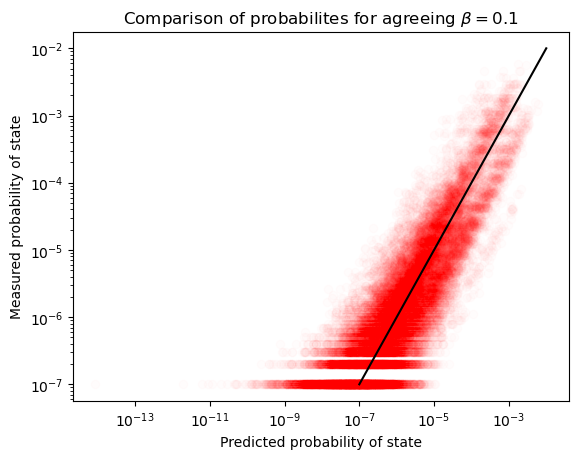

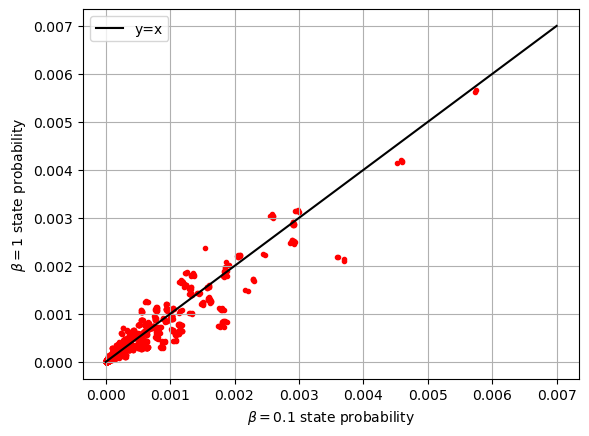
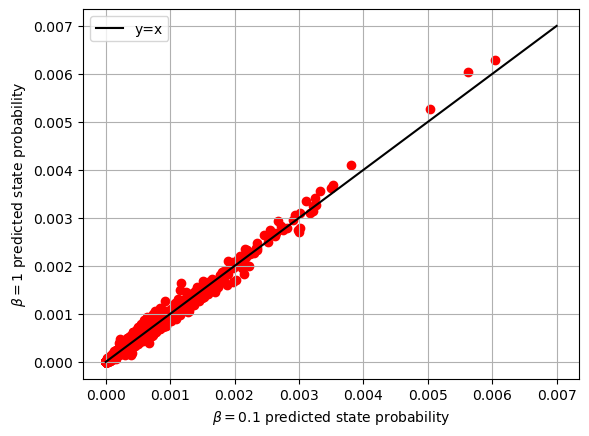

What we notice from these plots, is that the transformer seems to not have much variation in $\beta$ as the QMC has and it also predicts probabilities only to within an order of magnitude which isn't very good.

Another metric that can be computed is the average energy, computed in the same way that VMC computes it for the optimization.

$$\langle E \rangle = \langle \psi \vert \mathcal{H} \vert\psi\rangle = \sum_{z,z'} \psi(z)\psi(z')\mathcal{H}_{z,z'}$$
$$=\sum_z |\psi(z)|^2\sum_{z'} \frac{\psi(z')}{\psi(z)}\mathcal{H}_{z,z'}$$
$$\mathcal{H}=\frac{\Omega}{2}\sum_i \sigma^x - \delta \sum_i n_i +\sum_{i<j} V_{ij} n_i n_j$$

The hope for RydbergGPT is that even though we're not training on the energy, just on QMC data, the transformer will still learn the relationships between states to give a good estimate of $\langle E\rangle$ despite $P(x)$ being quite wrong.

Calculating the energy, I got a result that looked like:

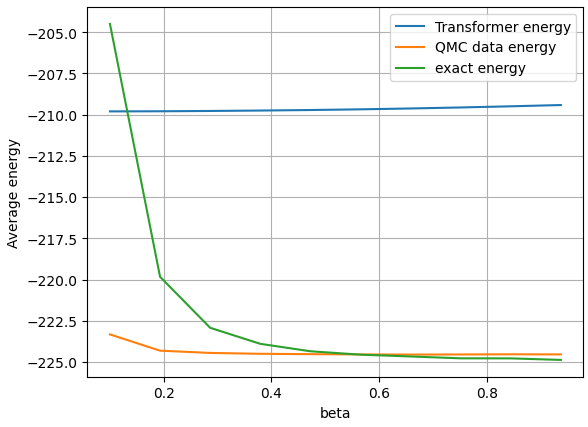

I notice that the transformer performs quite badly on this data. It not only gets a quite wrong value for the energy, but it also increases with $\beta$ as supposed to decreasing.

Note that the QMC will approach the exact energy if the number of samples go to infinity. We can see this in the following two plots, where the first is computing the energy with $10^7$ QMC samples and the second has only $10^6$ samples. The energy of the QMC data is by computing the probabilities of each state and computing energy from that. This value can be compared with the more precise energy which is calculated more directly from QMC with the formula $\langle E\rangle =-\frac{\langle n\rangle}{\beta}$.

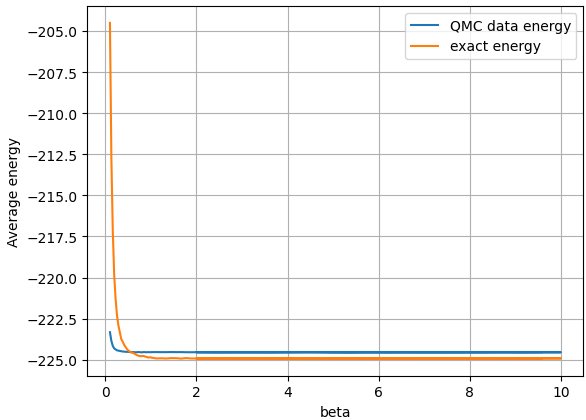
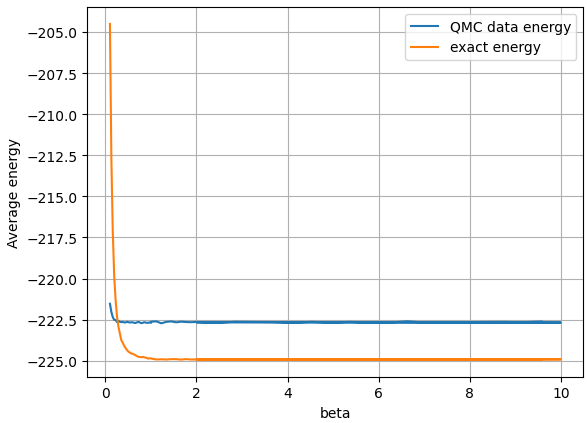

I then attempted to train the transformer on only subsets of the $\beta$ values. For example, training it on a single $\beta$ value. Or maybe a $\beta$ value in a high temperature and one on a low temperature, to see the interpolation.

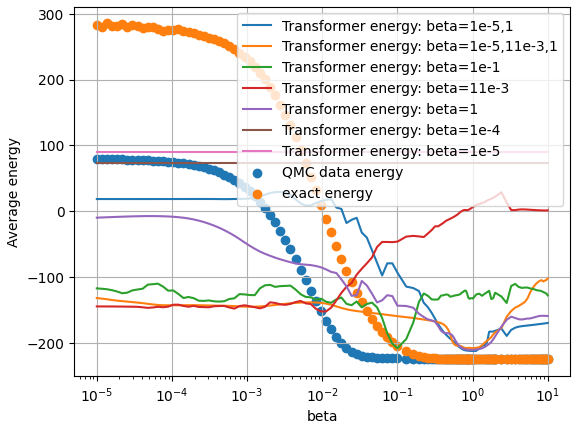

We notice that the transformers can only get so close to the QMC energy (after the transformer converges). Some interpolation can be seen, but neither side of the energy curve reaches energies that the QMC plot gets. In addition, we notice that the transformer energy is approaching the QMC energy rather than the exact energy.

## Schuyler data
### Data Analysis
We obtained some data on Harvard's neutral atom quantum computer. For the experiment, they tested out a bunch of sweeping rates for the adiabatic state preparation. Roger then made hypothesis that the sweep rate has some affect on the temperature that we observe. 

To begin with, the dataset doesn't have enough iterations to get a good error estimate of the JSD between the data and QMC, espeically since it is 12x12 (or larger). So the only way (so far at least) to compute the temperature is with the average occupation.

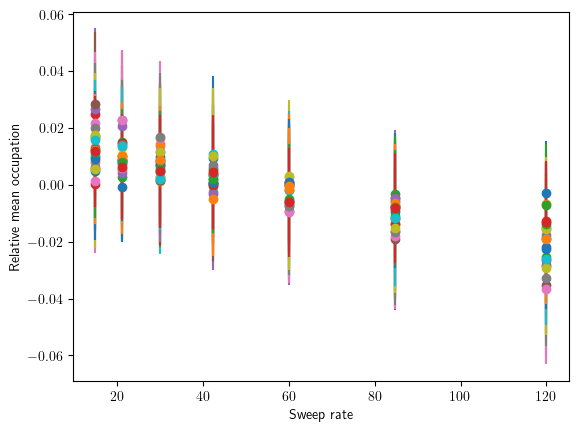

When computing how the average occupation changes as a function of the sweep rate, we notice that, for different points on the phase space, the average occupation tends to decrease with sweeping rate. In most cases, decreasing occupation means a decrease in temperature. This would suggest that higher sweep rates have a lower temperature. This is somewhat of an unintuitive result, as one would expect more noise to come from, the state preparation being too quick and not being adiabatic. We will employ another test to confirm whether this conclusion is accurate.

### Neural network training
The idea is to, instead of computing the temperature via average occupation, we compute the temperature via average energy. We know that the energy monotonically (at the very least for points on the phase diagram I've checked) increases with temperature, so when compuing the energy, we can find the temperature. The means to compute the energy is by training a neural network and taking the average of the sampled local energy as mentioned before.

For this test, I wanted to try out three different neural networks to benchmark them. The RNN, the transformer and a new neural network I learned about called the [RetNet](https://arxiv.org/abs/2307.08621). This neural network takes the fast inference/sampling of RNNs and the parrelized training of transformers and combines them into a single model. It does this by having three equivalent forms that the weights can be used, one for inference, one for parralelized training, and a hybrid of the two.

When actually implementing this, I only ended up implementing an RNN and a RetNet. I trained these neural networks on Schuyler's data and outputted the final energy after convergence. Since the dataset is quite small, overfitting has the results in the energy increasing again. As such we pick the minimum energy found in the training. To get error bars, I trained various different neural networks independently to see which energies they converged on.

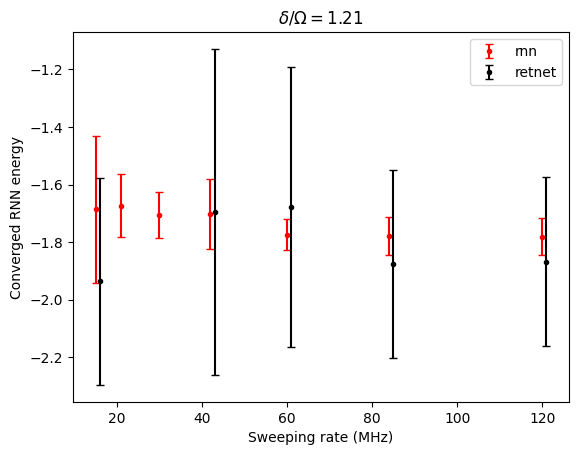
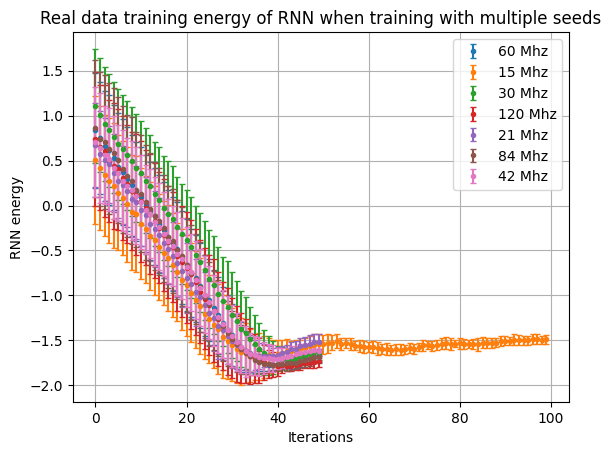

This result seems to corroborate having that increasing the sweeping rate decreases the temperature. Though the error bars are quite large. The RetNet also likely has such large errors due to the RetNet having more parameters.



## Combining training methods
Inspired by a paper from [Stephanie Czischek](https://arxiv.org/pdf/2203.04988.pdf), I wanted to see how changing the loss function of the neural network affected training. If we were to swap between a VMC loss function and a data based (negative log likelihood) loss function, could it increase the rate of convergence of VMC or of data training? And could it increase the accuracy of the final energy converged to when doing data training. The idea here was that when training on data, the neural network will reach a minimum energy and then increase when overfitting, but this energy might be larger than the true energy and it will never get as low as the true energy. Maybe we could use the VMC loss function to find something close to the ground state and then train on the data to add some noise to make the state close to the true state, where here we're increasing the energy to reach the true state's energy.

I trained the RetNet and RNN on real data and obtained the following result. It seems that RetNet converges on the correct state more quickly than RNN.

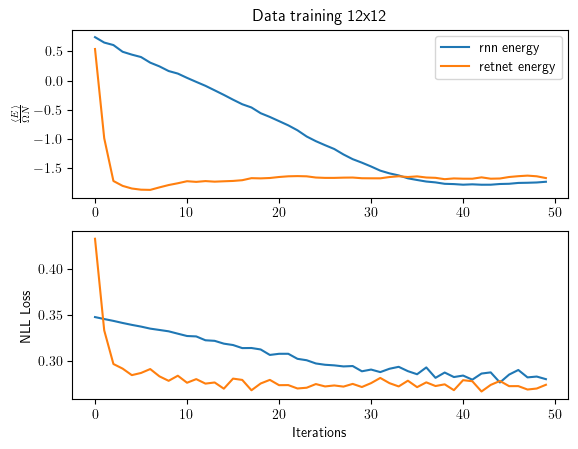

I was also testing with VMC, but sometimes I obtained energies that were lower than the QMCs. The same thing happened when I was training on QMC data. Obviously there is a problem with this.

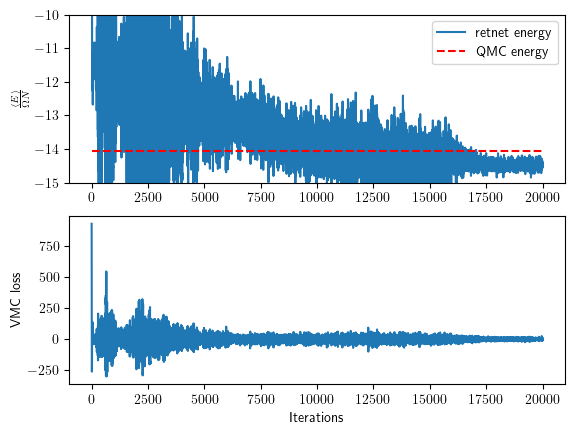

I didn't have time to look more into this and perform more tests. And so I didn't get the opportunity to look more into swapping between VMC and data training.

# Other Testing
## Autocorrelation Testing for QMC

My approach for testing autocorrelation was as follows:
1. Suppose you have a sequence of vectors, where the vectors have 1s or 0s. We can count the number of bit flips to go from one vector to the other, as a measure of correlation. 
1. We can make a histogram of the number of bit flips between adjacent vectors. This is the fully correlated histogram
1. We can make a histogram of the number of bit flips between adjacent vectors after shuffling the vectors. These vectors should be completely uncorrelated. 
1. We can make a histogram of the number of bit flips between vectors that are some number of iterations away from each other. If the number of iterations between vectors is equal to the autocorrelation time, the corresponding histogram should be the same as that of the completely uncorrelated data, as supposed to the completely correlated data.


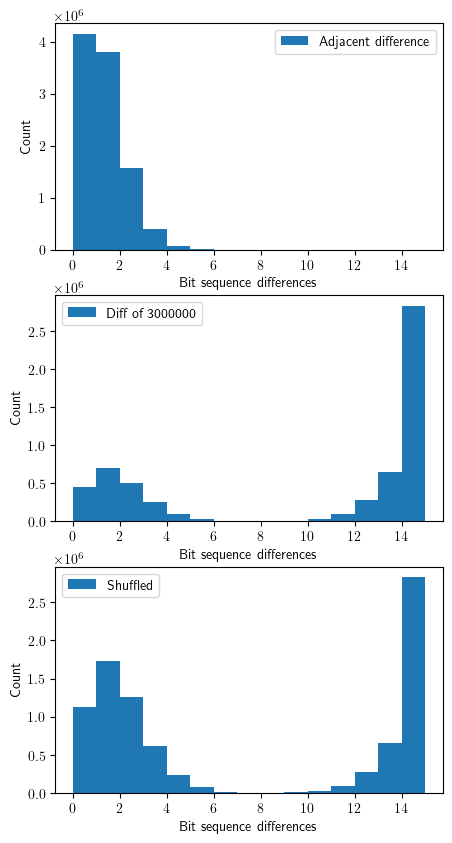

Uncorrelation time for QMC

|      |$\beta\Omega=2.51$ | $\beta\Omega=4.02$ | $\beta\Omega=4.77$  | $\beta\Omega=25.1$ |
|------|-------------------|--------------------|---------------------|--------------------|
|$\Delta/\Omega=0.5$| it is mostly uncorrelated after 20-30 iterations | ||it is mostly uncorrelated after 20-30 iterations|
|$\Delta/\Omega=1.1$| it is mostly uncorrelated after 200-300 iterations| ||it is mostly uncorrelated after ~800 iterations|
|$\Delta/\Omega=2.7$| it is mostly uncorrelated after ~50,000 iterations| it is mostly uncorrelated after ~500,000-1,000,000+ iterations|it is mostly uncorrelated after ~3,000,000+ iterations (can't fully test with this approach)|it is mostly uncorrelated after 30-40 iterations|

For the checkerboard pattern, the autocorrelation time is too large (larger than $10^7$) so the state becomes non-ergotic for even reasonably somewhat high temperatures. 

## Temperature vs energy
The following plot was made using energies calculated from QMC data. This was done with a 4x4 Rydberg atom array, and the x and y axis are in terms of dimensionless quantities. As such, this diagram doesn't depend on $\Omega$. The plot will vary based on the point in the phase space, but will have the transition vaguely around the same place and will have the same general shape.

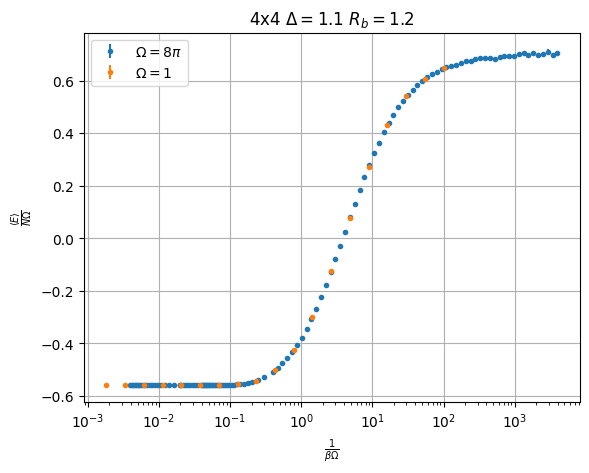

The diagram gives an intuition for which values of $\beta\Omega$ correspond to the ground state. When training neural networks, you will want to have the full spectrum of $\beta\Omega$ values, as supposed to training on only arrays in the ground state.

# Guides
## Using AWS Braket to access Aquila
AWS Braket is the service that AWS has for allowing users to use its quantum computers over the cloud. AWS has many quantum computers available at different times, each with different capabilities. The quantum computer I got access to was Aquila, which is a neutral atom quantum computer.

### Getting AWS account
You want to use your own aws account rather than the root user. The root user is connected to an email, thus if aws decides to confirm who you are by sending a verification code to the email, you will need to access the email to login. 

1. Log into the root and create an iam user in the `researcher` group. You can add any other permissions you need, but ideally this will be enough. 
2. Click on the iam user, and under "Summary", and under "Access Key 1" press "Create Access Key". Once created, don't lose this since you will not be able to access it again. Be careful of this since it will allow anyone to access the services. 
3. In order for the new user to actually log in, go to the "Security credentials" tab, press "Enable console access". Press "enable", pick either "set password option" and press "User must create new password at next sign-in". 
4. Login to newly created iam user and create new password. 
5. You can now access whatever you need to on aws.

### Pricing
When sending a request to each of AWS's quantum computers, it is setup in the following way. A single task is something that shows up on the AWS task display.

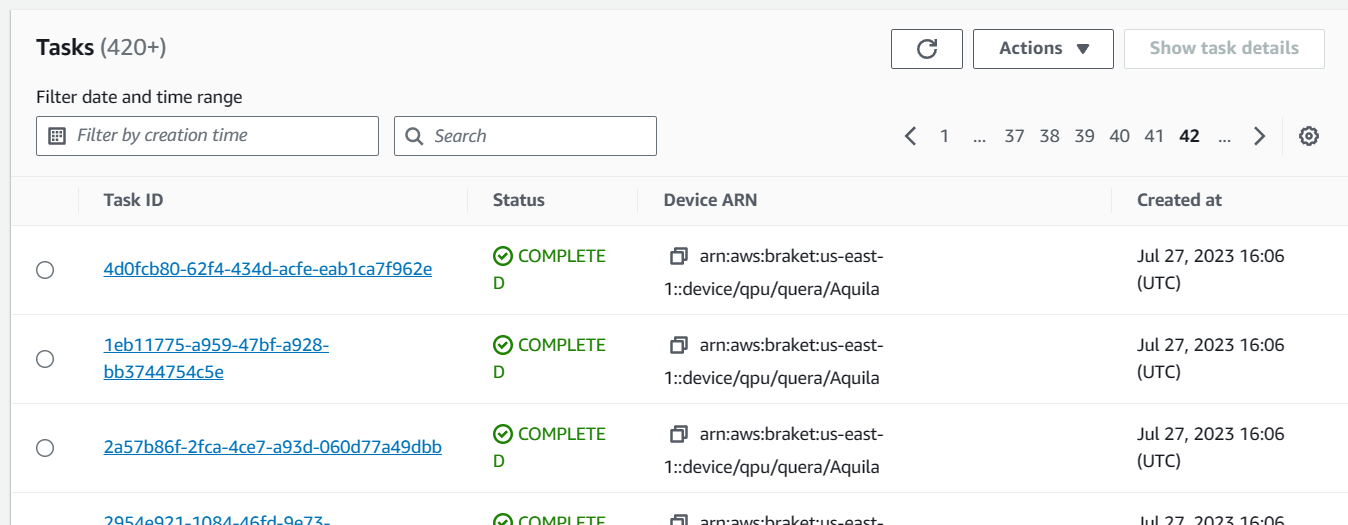

Each task can have up to 1000 shots. For the case of Aquila, each shot of a task will be a repetition of the same experiment (though this may not be entirely true). In order to get a large amount of shots, you will have to run many tasks, each with 1000 shots.

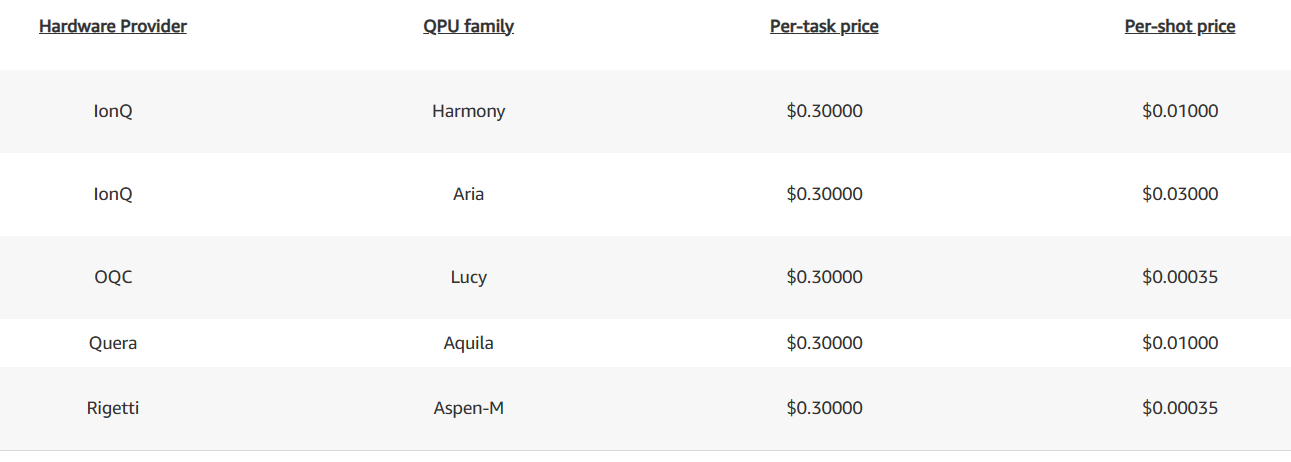

If you have a task of 1000 shots, the pricing will be $\$0.3 + 1000\times \$0.01=\$10.3/\text{task}$. This gives a price per shot of $\$0.0103$.

You don't have to worry about incurring any other costs (except maybe s3, but so long as you remove the data from s3 eventually you'll at most be charged a cent). 

### Running shots on quantum computer

There are two general ways of using aws braket. You can use a task or a job. 

A job is a hybrid method to access the quantum computer which gives you high priority in the queue. It does this because it aims to allow you to send data to the quantum computer, analyze the data, and send a new request to the quantum computer, all in a loop. The downside is that this comes with extra cost. We will not be using this functionality. Tasks are what was stated previously, and will be what we use.

In order to make use of either a task or a job, you will have to access the aws sdk, either on python, julia, or any other language that aws supports. Commonly with python, you can access the services through the module `boto3`. In the case of Braket, we also access AWS through the Braket SDK [here](https://amazon-braket-sdk-python.readthedocs.io/en/stable/_apidoc/braket.aws.aws_device.html). 

To use the Braket SDK, we need a `boto3` session. For this, we either need an access key, or we can run everything on an AWS notebook where the access key is already supplied. For my case, I just got the access key and used the following python code to send a task.
```python
from boto3 import Session
from braket.aws import AwsDevice, AwsSession
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

ahs_program = AnalogHamiltonianSimulation(
    register=register,
    hamiltonian=H,
)
boto_session = Session(
    aws_access_key_id="<insert access key id here>",
    aws_secret_access_key="<insert secret access key here>",
    region_name="us-east-1")
aws_session = AwsSession(boto_session)

aquila = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila", aws_session)
discretized_ahs_program = ahs_program.discretize(aquila)


nshots = 1000
for i in range(104):
    task = aquila.run(discretized_ahs_program, shots=nshots, s3_destination_folder=(aquila._aws_session.default_bucket(),'<folder name>'))
```
When run properly, your tasks should show up in the task view on AWS.


# Resources
1. [Aquila: QuEra's 256-qubit neutral-atom quantum computer](https://arxiv.org/abs/2306.11727)
1. [AWS Braket SDK](https://amazon-braket-sdk-python.readthedocs.io/en/stable/_apidoc/braket.aws.aws_device.html)
1. [RetNet source code](https://github.com/microsoft/torchscale/tree/main/torchscale/architecture), [RetNet Paper](https://arxiv.org/abs/2307.08621)
1. [Transformer quantum state](https://arxiv.org/abs/2208.01758)
1. [VMC Patched transformers](https://arxiv.org/abs/2306.03921)
1. [Data enhanced VMC](https://arxiv.org/pdf/2203.04988.pdf)